In [3]:
import pandas as pd
import numpy as np
from pathlib import Path
import missingno as msno
from collections import defaultdict
from tqdm.notebook import tqdm
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot as plt

## 02 - Interpolating Missing Values

In this notebook, we examine the issue of gaps in the time series and explore seasonal interpolation as a strategy for filling these gaps.

In [7]:
preprocessed = Path('../data/preprocessed')

We examine the first set of 8 blocks:

In [16]:
block_df = pd.read_parquet(preprocessed/'london_smart_meters_merged_block_0-7.parquet')

In [17]:
block_df.head()

,LCLid,start_timestamp,frequency,energy_consumption,series_length,stdorToU,Acorn,Acorn_grouped,file,holidays,...,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,precipType,icon,humidity,summary
0,MAC000002,2012-10-13,30min,"[0.263, 0.2689999999999999, 0.275, 0.256, 0.21...",24144,Std,ACORN-A,Affluent,block_0,"[NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDA...",...,"[186, 186, 188, 188, 190, 190, 203, 203, 206, ...","[8.78, 8.78, 8.27, 8.27, 7.87, 7.87, 7.89, 7.8...","[6.28, 6.28, 6.21, 6.21, 6.22, 6.22, 6.76, 6.7...","[1007.7, 1007.7, 1007.36, 1007.36, 1006.73, 10...","[7.55, 7.55, 7.34, 7.34, 6.75, 6.75, 6.89, 6.8...","[2.28, 2.28, 1.81, 1.81, 1.95, 1.95, 1.83, 1.8...","[rain, rain, rain, rain, rain, rain, rain, rai...","[clear-night, clear-night, clear-night, clear-...","[0.84, 0.84, 0.87, 0.87, 0.89, 0.89, 0.93, 0.9...","[Clear, Clear, Clear, Clear, Partly Cloudy, Pa..."
1,MAC000246,2012-01-01,30min,"[0.509, 0.317, 0.253, 0.249, 0.93, 0.607, 0.10...",37872,Std,ACORN-A,Affluent,block_0,"[NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDA...",...,"[229, 229, 238, 238, 229, 229, 231, 231, 227, ...","[12.12, 12.12, 12.59, 12.59, 12.45, 12.45, 12....","[10.97, 10.97, 11.02, 11.02, 11.04, 11.04, 10....","[1008.1, 1008.1, 1007.88, 1007.88, 1007.95, 10...","[12.12, 12.12, 12.59, 12.59, 12.45, 12.45, 12....","[5.9, 5.9, 6.06, 6.06, 5.31, 5.31, 4.68, 4.68,...","[rain, rain, rain, rain, rain, rain, rain, rai...","[partly-cloudy-night, partly-cloudy-night, clo...","[0.93, 0.93, 0.9, 0.9, 0.91, 0.91, 0.93, 0.93,...","[Mostly Cloudy, Mostly Cloudy, Overcast, Overc..."
2,MAC000450,2012-03-23,30min,"[1.337, 1.426, 0.996, 0.971, 0.994, 0.952, 0.8...",33936,Std,ACORN-A,Affluent,block_0,"[NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDA...",...,"[78, 78, 73, 73, 81, 81, 80, 80, 75, 75, 71, 7...","[8.76, 8.76, 8.54, 8.54, 8.09, 8.09, 7.34, 7.3...","[7.25, 7.25, 7.12, 7.12, 7.17, 7.17, 6.68, 6.6...","[1027.41, 1027.41, 1026.91, 1026.91, 1026.54, ...","[7.59, 7.59, 7.43, 7.43, 7.24, 7.24, 7.34, 7.3...","[2.18, 2.18, 2.07, 2.07, 1.72, 1.72, 1.34, 1.3...","[rain, rain, rain, rain, rain, rain, rain, rai...","[fog, fog, fog, fog, fog, fog, fog, fog, fog, ...","[0.9, 0.9, 0.91, 0.91, 0.94, 0.94, 0.96, 0.96,...","[Foggy, Foggy, Foggy, Foggy, Foggy, Foggy, Fog..."
3,MAC001074,2012-05-09,30min,"[0.18, 0.086, 0.106, 0.173, 0.146, 0.223, 0.21...",31680,ToU,ACORN-,ACORN-,block_0,"[NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDA...",...,"[215, 215, 207, 207, 215, 215, 216, 216, 126, ...","[11.46, 11.46, 11.38, 11.38, 11.38, 11.38, 10....","[10.23, 10.23, 10.17, 10.17, 10.24, 10.24, 10....","[1007.39, 1007.39, 1007.21, 1007.21, 1007.06, ...","[11.46, 11.46, 11.38, 11.38, 11.38, 11.38, 10....","[2.35, 2.35, 2.15, 2.15, 1.84, 1.84, 1.22, 1.2...","[rain, rain, rain, rain, rain, rain, rain, rai...","[partly-cloudy-night, partly-cloudy-night, par...","[0.92, 0.92, 0.92, 0.92, 0.93, 0.93, 0.95, 0.9...","[Partly Cloudy, Partly Cloudy, Mostly Cloudy, ..."
4,MAC003223,2012-09-18,30min,"[0.076, 0.079, 0.123, 0.109, 0.051, 0.069, 0.0...",25344,Std,ACORN-A,Affluent,block_0,"[NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDA...",...,"[236, 236, 240, 240, 242, 242, 244, 244, 248, ...","[14.06, 14.06, 13.12, 13.12, 12.53, 12.53, 12....","[10.82, 10.82, 10.29, 10.29, 9.86, 9.86, 9.83,...","[1011.09, 1011.09, 1010.82, 1010.82, 1010.65, ...","[14.06, 14.06, 13.12, 13.12, 12.53, 12.53, 12....","[3.86, 3.86, 3.81, 3.81, 4.27, 4.27, 4.12, 4.1...","[rain, rain, rain, rain, rain, rain, rain, rai...","[clear-night, clear-night, clear-night, clear-...","[0.81, 0.81, 0.83, 0.83, 0.84, 0.84, 0.86, 0.8...","[Clear, Clear, Clear, Clear, Clear, Clear, Par..."


We need to convert the compact form of the time series columns into the expanded form to make them easier to work with.

We define a function for converted each time series from its compact form to expanded form:

In [18]:
def compact_to_expanded(df, timeseries_col, static_cols, time_varying_cols, ts_identifier):
    """Takes a DataFrame in compact form, a time series column name, a list of static columns a list of time-varying columns and a time series identifier.
    Returns the DataFrame converted to expanded form."""
    def preprocess_expanded(x):
        # Create a date range from start
        dr = pd.date_range(
            start=x['start_timestamp'],
            periods=len(x['energy_consumption']),
            freq=x['frequency'],
        )
        # Build a dictionary of lists for each of our columns,
        # then convert this into a DataFrame for that time series
        df_columns = defaultdict(list)
        df_columns['timestamp'] = dr
        for col in [ts_identifier, timeseries_col] + static_cols + time_varying_cols:
            df_columns[col] = x[col]
        return pd.DataFrame(df_columns)

    # Expand each time series row, then join these expansions together into a single DataFrame
    all_series = []
    for i in tqdm(range(len(df))):
        all_series.append(preprocess_expanded(df.iloc[i]))
    df = pd.concat(all_series)
    del all_series
    return df

We convert the last block in the group (block 7) to expanded form for inspection:

In [19]:
# Convert block 7 to expanded form
exp_block_df = compact_to_expanded(block_df[block_df.file=='block_7'], timeseries_col = 'energy_consumption',
static_cols = ['frequency', 'series_length', 'stdorToU', 'Acorn', 'Acorn_grouped', 'file'],
time_varying_cols = ['holidays', 'visibility', 'windBearing', 'temperature', 'dewPoint',
       'pressure', 'apparentTemperature', 'windSpeed', 'precipType', 'icon',
       'humidity', 'summary'],
ts_identifier = 'LCLid')

exp_block_df.head()

  0%|          | 0/50 [00:00<?, ?it/s]

,timestamp,LCLid,energy_consumption,frequency,series_length,stdorToU,Acorn,Acorn_grouped,file,holidays,...,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,precipType,icon,humidity,summary
0,2012-01-01 00:00:00,MAC000050,0.175,30min,37872,Std,ACORN-D,Affluent,block_7,NO_HOLIDAY,...,229,12.12,10.97,1008.10,12.12,5.90,rain,partly-cloudy-night,0.93,Mostly Cloudy
1,2012-01-01 00:30:00,MAC000050,0.212,30min,37872,Std,ACORN-D,Affluent,block_7,NO_HOLIDAY,...,229,12.12,10.97,1008.10,12.12,5.90,rain,partly-cloudy-night,0.93,Mostly Cloudy
2,2012-01-01 01:00:00,MAC000050,0.313,30min,37872,Std,ACORN-D,Affluent,block_7,NO_HOLIDAY,...,238,12.59,11.02,1007.88,12.59,6.06,rain,cloudy,0.90,Overcast
3,2012-01-01 01:30:00,MAC000050,0.302,30min,37872,Std,ACORN-D,Affluent,block_7,NO_HOLIDAY,...,238,12.59,11.02,1007.88,12.59,6.06,rain,cloudy,0.90,Overcast
4,2012-01-01 02:00:00,MAC000050,0.257,30min,37872,Std,ACORN-D,Affluent,block_7,NO_HOLIDAY,...,229,12.45,11.04,1007.95,12.45,5.31,rain,partly-cloudy-night,0.91,Mostly Cloudy


We can use the missingno package to highlight which dates and households are missing bits of their time series:

<Axes: >

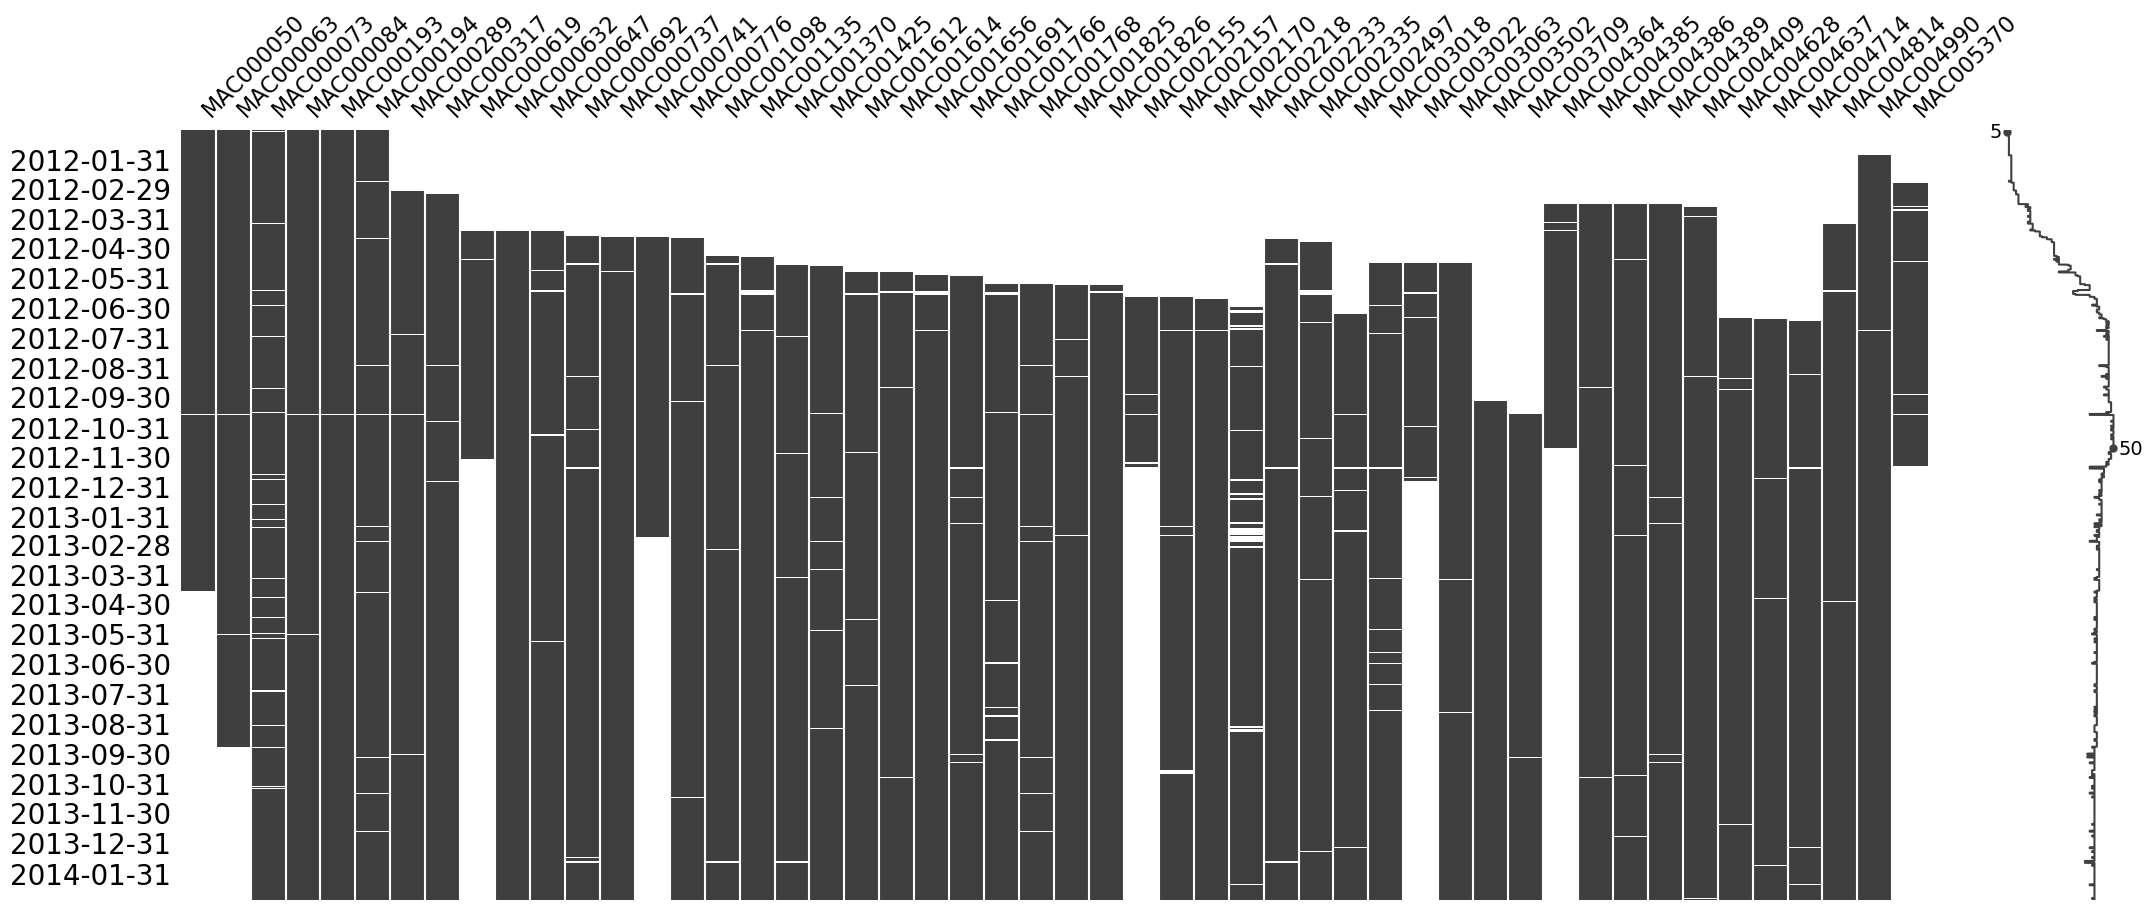

In [20]:
# Pivot the data to set the index as the datetime and the different time series along the columns
plot_df = pd.pivot_table(exp_block_df, index='timestamp', 
columns='LCLid', values='energy_consumption')
msno.matrix(plot_df, freq='M')


The big gaps we can see at the beginning of some of these series shows us that data consumption for some households started later than others. A few series finished early, which might mean that they dropped out of the program. 

The sparkline to the right of the plot shows us the "completeness" of the data - the further to the right this line is, the more complete each row is.

We can see that there are values missing for the LCLid MAC000193, so let's focus on the period between 2012-09-30 and 2012-10-31 for this household:

<Axes: >

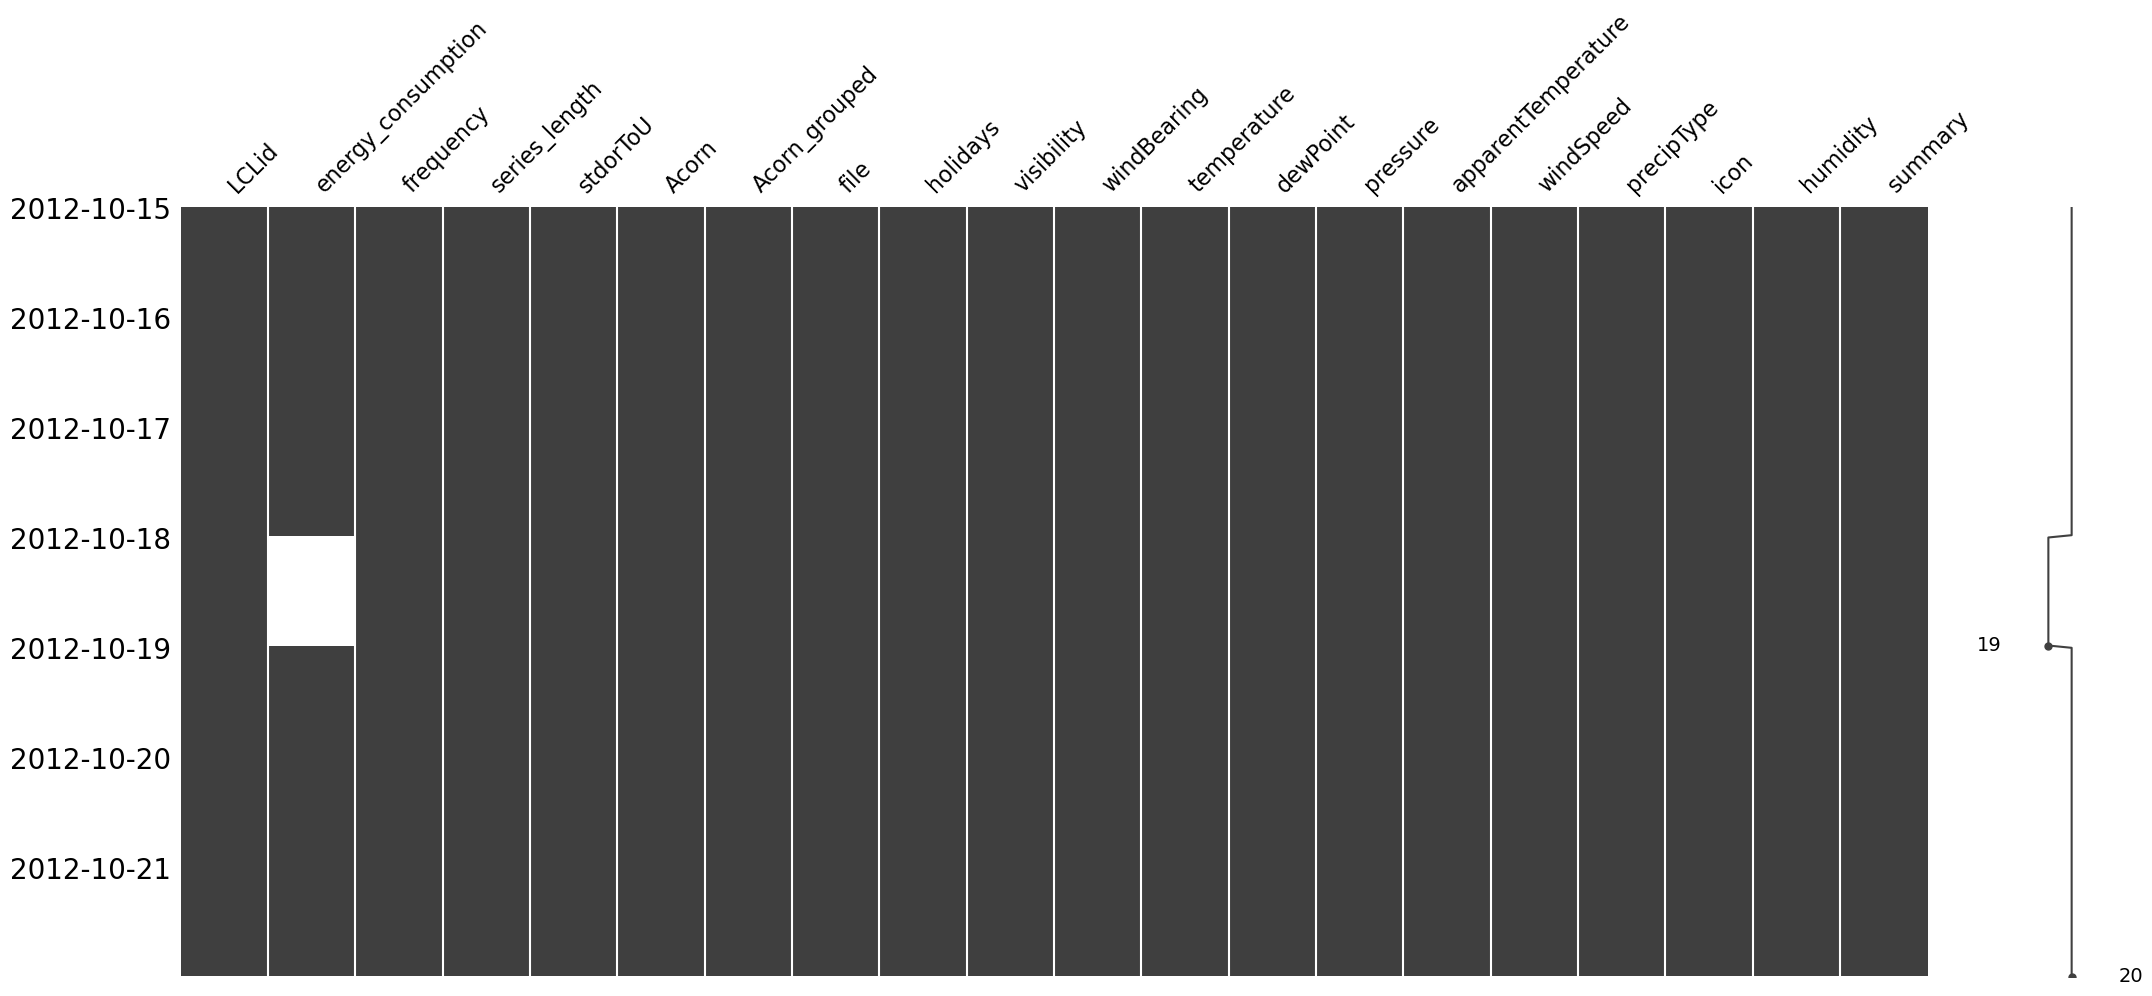

In [21]:
start_index = '2012-10-15'  # Start index of the slice
end_index = '2012-10-21'  # End index of the slice
ts_df = exp_block_df[exp_block_df.LCLid=="MAC000193"].set_index("timestamp")

msno.matrix(ts_df[start_index: end_index], freq="D")

We can use seasonal interpolation to fill in the missing values. This process consists of:

1) calculating the seasonal profile
2) subtracting the seasonal profile from the series and interpolating
3) adding the seasonal profile back in to the interpolated series

In [23]:
data = ts_df.energy_consumption

<Axes: xlabel='timestamp'>

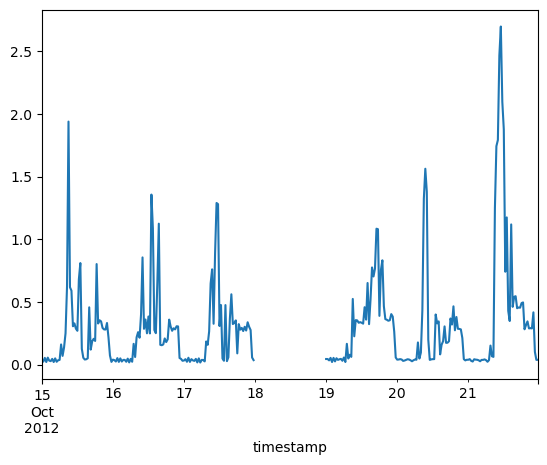

In [24]:
data[start_index: end_index].plot()

In [26]:
res = data.copy()
# seasonal_decompose doesn't work where the series has missing values,
# so for now we interpolate these (using limit_direction = 'both')

na_index = pd.isna(data)
temp = data.interpolate(method='spline', order=3, limit_direction = 'both')
dr = seasonal_decompose(temp, period=48*7)
# join trend and irregular component (timeseries without seasonality):
data_no_seasonality = dr.trend + dr.resid
# fill in NA values:
data_no_seasonality[na_index] = np.nan
# interpolate data without seasonality:
data_no_seasonality_imputed = data_no_seasonality.interpolate(method='spline', order=3, limit_direction = 'both')
# add back seasonality:
data_imputed = data_no_seasonality_imputed + dr.seasonal
# merge interpolated values into original timeseries:
res[na_index] = data_imputed[na_index]

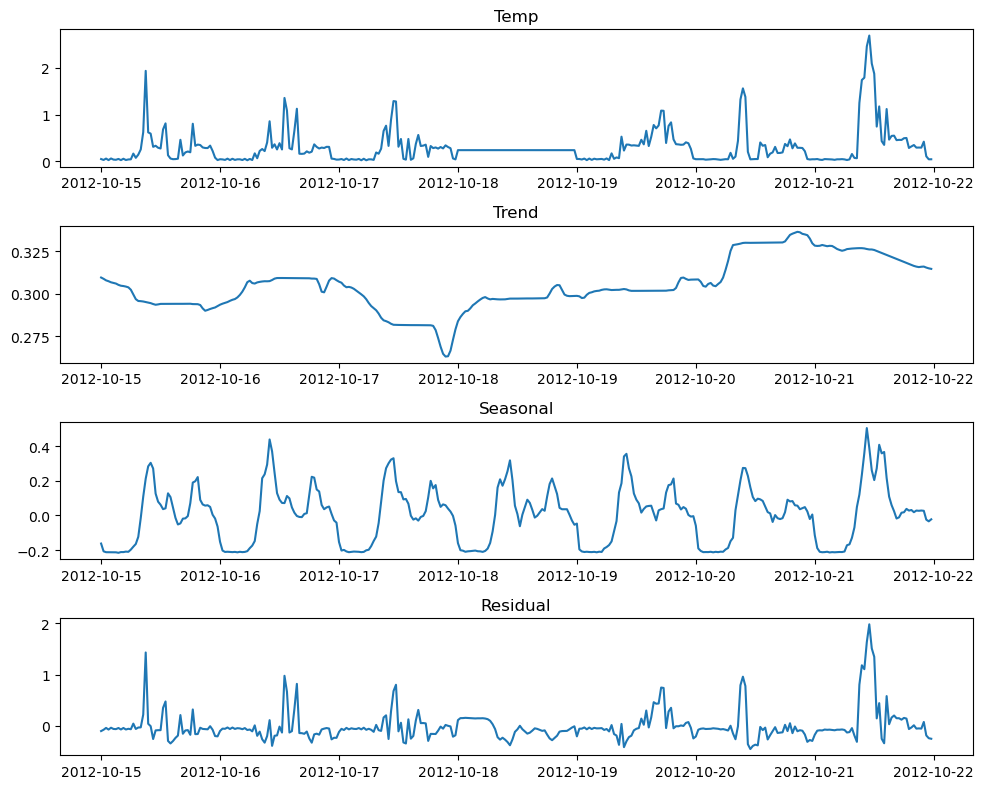

In [27]:
# Access and slice the components
trend = dr.trend
seasonal = dr.seasonal
residual = dr.resid

# Define the time index for plotting
time_index = range(len(data))

# Plot the sliced portion
plt.figure(figsize=(10, 8))

plt.subplot(4, 1, 1)
plt.plot(temp[start_index:end_index])
plt.title('Temp')

plt.subplot(4, 1, 2)
plt.plot(trend[start_index:end_index])
plt.title('Trend')

plt.subplot(4, 1, 3)
plt.plot(seasonal[start_index:end_index])
plt.title('Seasonal')

plt.subplot(4, 1, 4)
plt.plot(residual[start_index:end_index])
plt.title('Residual')

plt.tight_layout()
plt.show()

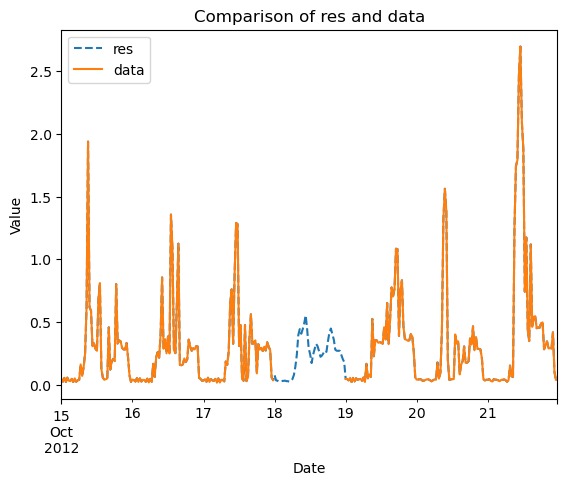

In [28]:
# Plotting res and data on the same figure
fig, ax = plt.subplots()

res[start_index:end_index].plot(ax=ax, linestyle='--', label='res')
data[start_index:end_index].plot(ax=ax, linestyle='-', label='data')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Comparison of res and data')

# Add legend
plt.legend()

# Show the plot
plt.show()